In [26]:
#importing the libreries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [27]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=5

In [28]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Pepper",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2475 files belonging to 2 classes.


In [29]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

In [30]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 0 1 0 0 0 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1]


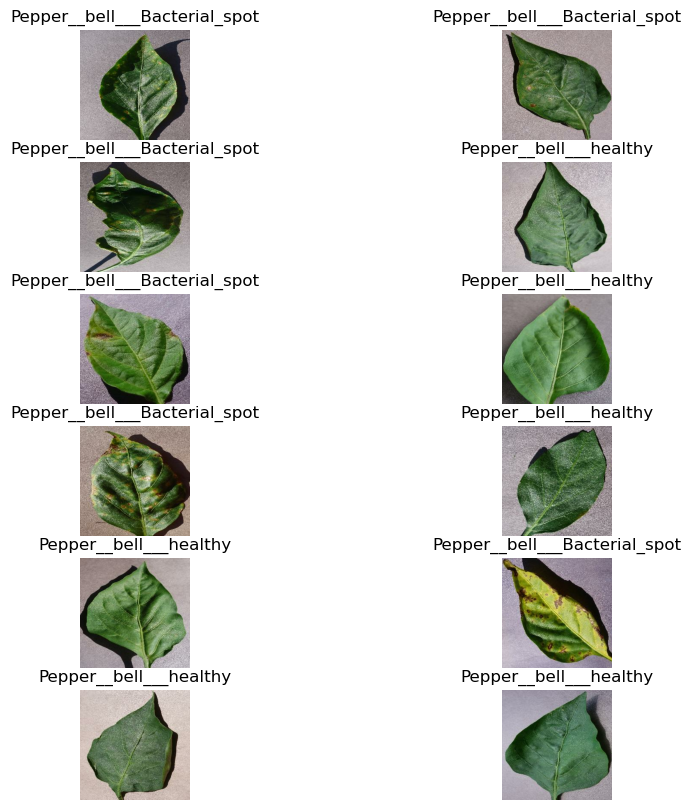

In [31]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(6, 2, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [32]:
len(dataset)

78

In [34]:
train_size = 0.8
len(dataset)*train_size

62.400000000000006

In [35]:
train_ds = dataset.take(54)
len(train_ds)

54

In [36]:
test_ds = dataset.skip(54)
len(test_ds)

24

In [37]:
val_size=0.1
len(dataset)*val_size

7.800000000000001

In [38]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [39]:
test_ds = test_ds.skip(6)
len(test_ds)

18

In [40]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [41]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [42]:
len(train_ds)

62

In [43]:
len(val_ds)

7

In [44]:
len(test_ds)

9

In [45]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [46]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

In [47]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [48]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [49]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

C:\Users\febin\.jupyter\anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [50]:
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [52]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=5
)

Epoch 1/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 220s 3s/step - accuracy: 0.5798 - loss: 0.8081 - val_accuracy: 0.6652 - val_loss: 0.6376
Epoch 2/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 200s 3s/step - accuracy: 0.7341 - loss: 0.5427 - val_accuracy: 0.8393 - val_loss: 0.4628
Epoch 3/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 220s 4s/step - accuracy: 0.8762 - loss: 0.2733 - val_accuracy: 0.9509 - val_loss: 0.1742
Epoch 4/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 193s 3s/step - accuracy: 0.9587 - loss: 0.1067 - val_accuracy: 0.9598 - val_loss: 0.1757
Epoch 5/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step - accuracy: 0.9757 - loss: 0.0769 - val_accuracy: 0.9688 - val_loss: 0.1904


In [53]:
model.save('pepper_bell_model.h5')

In [58]:
scores = model.evaluate(test_ds)

9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 712ms/step - accuracy: 0.9853 - loss: 0.0496


In [59]:
scores

[0.05372890457510948, 0.9895833134651184]

In [61]:
history

In [62]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 62}

In [63]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [64]:
type(history.history['loss'])

list

In [65]:
len(history.history['loss'])

5

In [66]:
history.history['loss'][:5]

[0.7118470072746277,
 0.48202425241470337,
 0.22037702798843384,
 0.09174685180187225,
 0.06805667281150818]

In [67]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

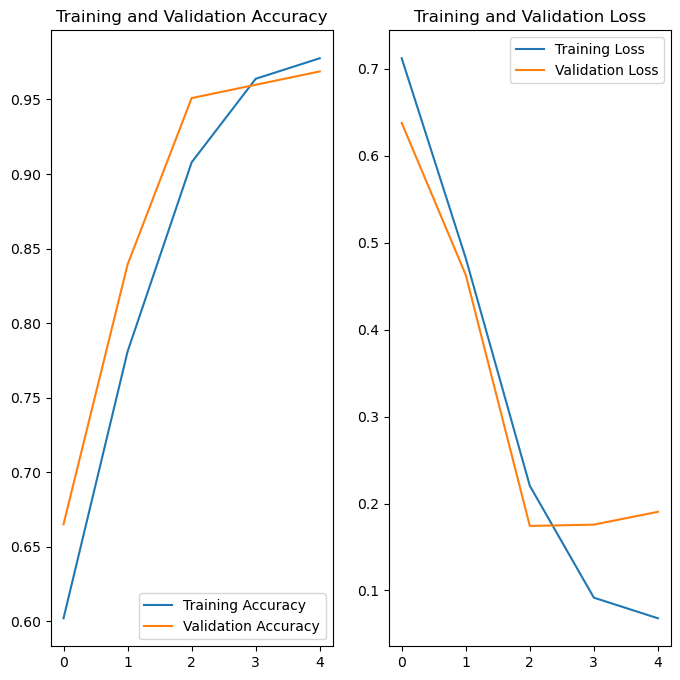

In [68]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Pepper__bell___healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
predicted label: Pepper__bell___healthy


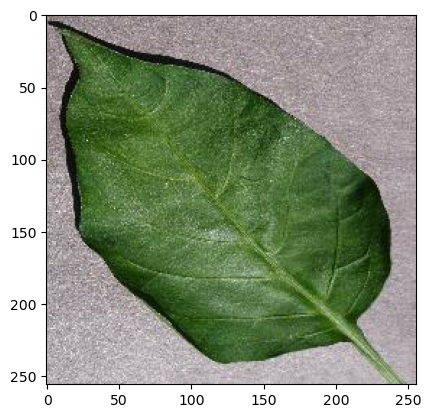

In [69]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [71]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


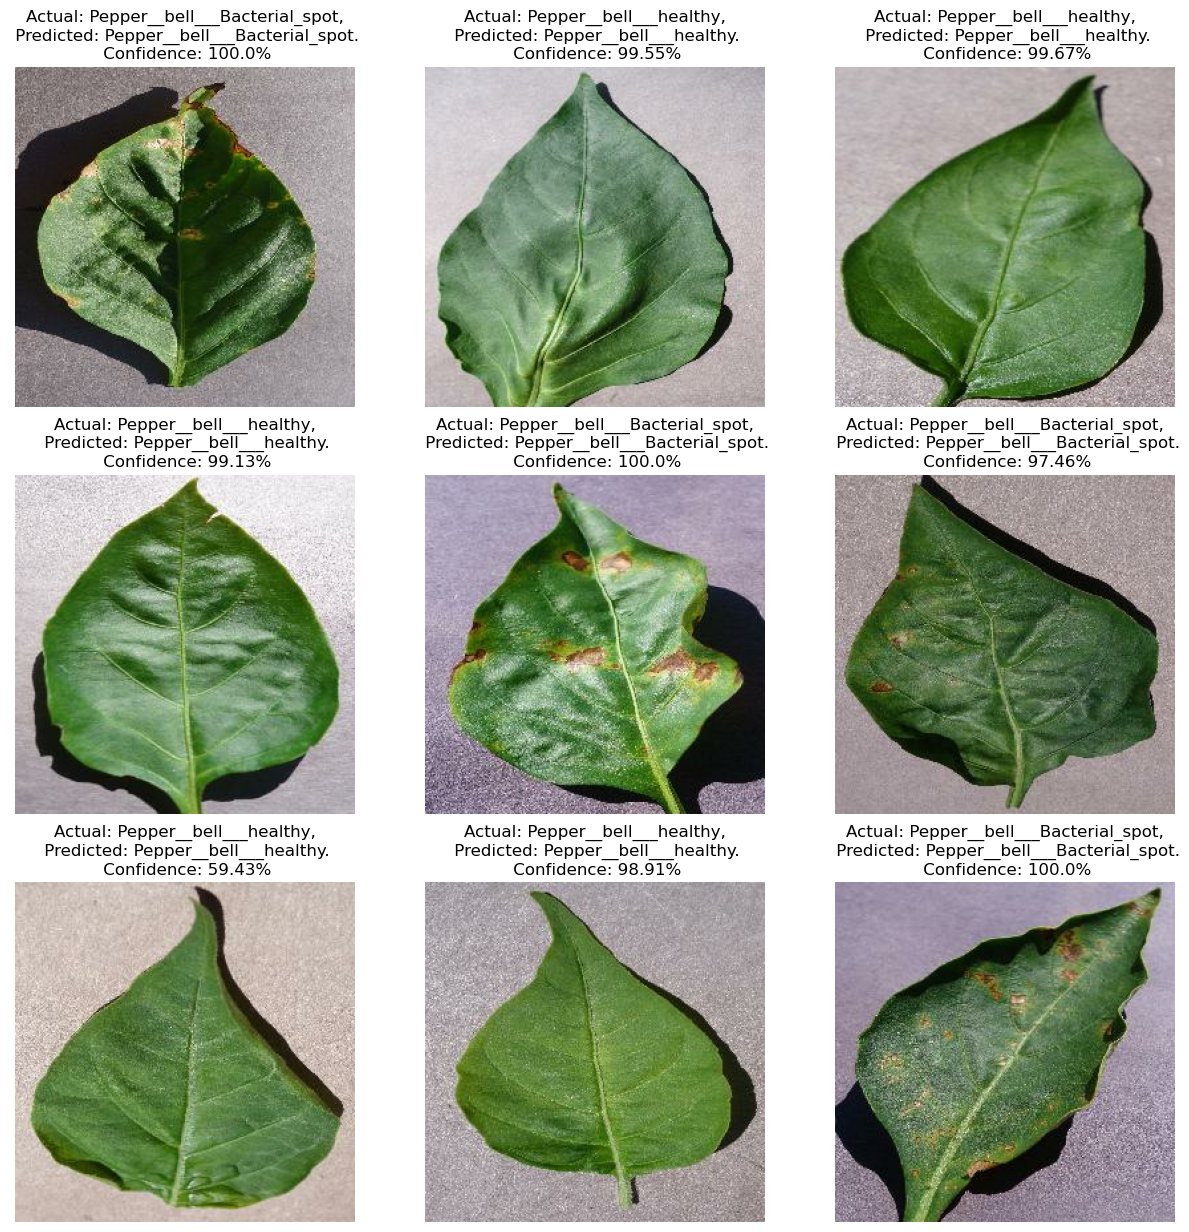

In [72]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [74]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk

In [75]:
class ImageUploaderApp:
    def __init__(self, master):
        self.master = master
        self.master.title("Image Uploader")

        self.image_label = tk.Label(master)
        self.image_label.pack()

        self.upload_button = tk.Button(master, text="Upload Image", command=self.upload_image)
        self.upload_button.pack()

    def upload_image(self):
        file_path = filedialog.askopenfilename(title="Select Image",
                                               filetypes=(("Image files", "*.jpg;*.jpeg;*.png;*.gif"), ("All files", "*.*")))
        if file_path:
            self.display_image(file_path)

    def display_image(self, file_path):
        image = Image.open(file_path)
        image = image.resize((300, 300), Image.ANTIALIAS)  # Resize the image
        photo = ImageTk.PhotoImage(image)

        self.image_label.configure(image=photo)
        self.image_label.image = photo  # Keep a reference to the image to prevent garbage collection

if __name__ == "__main__":
    root = tk.Tk()
    app = ImageUploaderApp(root)
    root.mainloop()

C:\Users\febin\AppData\Local\Temp\ipykernel_16848\1777825091.py:20: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize((300, 300), Image.ANTIALIAS)  # Resize the image


In [4]:
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk
import numpy as np
import tensorflow as tf


class ImageUploaderApp:
    def __init__(self, master):
        self.master = master
        self.master.title("Image Uploader")

        self.image_label = tk.Label(master)
        self.image_label.pack()

        self.upload_button = tk.Button(master, text="Upload Image", command=self.upload_image)
        self.upload_button.pack()

        # Load your pre-trained model
        self.model = tf.keras.models.load_model('pepper_bell_model.h5')

        # Dictionary mapping class indices to animal names
        self.class_index_to_class_names = {
             0:"Pepper__bell___Bacterial_spot",
             1: "Pepper__bell___healthy"
            
            
            # Add more mappings as per your model's output classes
        }

    def upload_image(self):
        file_path = filedialog.askopenfilename(title="Select Image",
                                               filetypes=(("Image files", "*.jpg;*.jpeg;*.png;*.gif"), ("All files", "*.*")))
        if file_path:
            self.display_image(file_path)
            self.predict_leaf(file_path)

    def display_image(self, file_path):
        image = Image.open(file_path)
        image = image.resize((300, 300), Image.ANTIALIAS)  # Resize the image
        photo = ImageTk.PhotoImage(image)

        self.image_label.configure(image=photo)
        self.image_label.image = photo  # Keep a reference to the image to prevent garbage collection

    def preprocess_image(self, image_path):
        img = Image.open(image_path)
        img = img.resize((128, 128))  # Resize the image to match model input size
        img_array = np.array(img) / 255.0  # Normalize the image
        return img_array

    def predict_leaf(self, image_path):
        try:
            image_array = self.preprocess_image(image_path)
        # Perform inference using your pre-trained model
            predictions = self.model.predict(np.expand_dims(image_array, axis=0))
            predicted_class= np.argmax(predictions)
            print("Predicted class index:", predicted_class)
            print("Class index to leaf mapping:", self.class_index_to_class_names)
            predicted_leaf = self.class_index_to_class_names.get(predicted_class, "Unknown")
            messagebox.showinfo("Prediction", f"The predicted leaf is: {predicted_leaf}")
        except Exception as e:
            messagebox.showerror("Error", f"An error occurred during prediction: {str(e)}")
if __name__ == "__main__":
    root = tk.Tk()
    app = ImageUploaderApp(root)
    root.mainloop()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


C:\Users\febin\AppData\Local\Temp\ipykernel_3176\560265878.py:40: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize((300, 300), Image.ANTIALIAS)  # Resize the image


Predicted class index: 0
Class index to leaf mapping: {0: 'Pepper__bell___Bacterial_spot', 1: 'Pepper__bell___healthy'}
